Using device: cpu
      simID  nSTA  videoQuality  twtWakeIntervalMultiplier  \
0  100022.0   1.0           1.0                        1.0   
1  101012.0   1.0           1.0                        1.0   
2  100990.0   1.0           1.0                        1.0   
3  100176.0   1.0           1.0                        1.0   
4  100176.0   1.0           1.0                        1.0   

   twtNominalWakeDurationDivider  nextStaTwtSpOffsetDivider  simulationTime  \
0                          200.0                        1.0            40.0   
1                          200.0                        1.0            40.0   
2                          200.0                        1.0            40.0   
3                          200.0                        1.0            40.0   
4                          200.0                        1.0            40.0   

   randSeed  StaMacAddress    UL_bits  ...  UL_latency_95th_us  \
0    1001.0            0.0  3817230.0  ...            922000.0   
1 

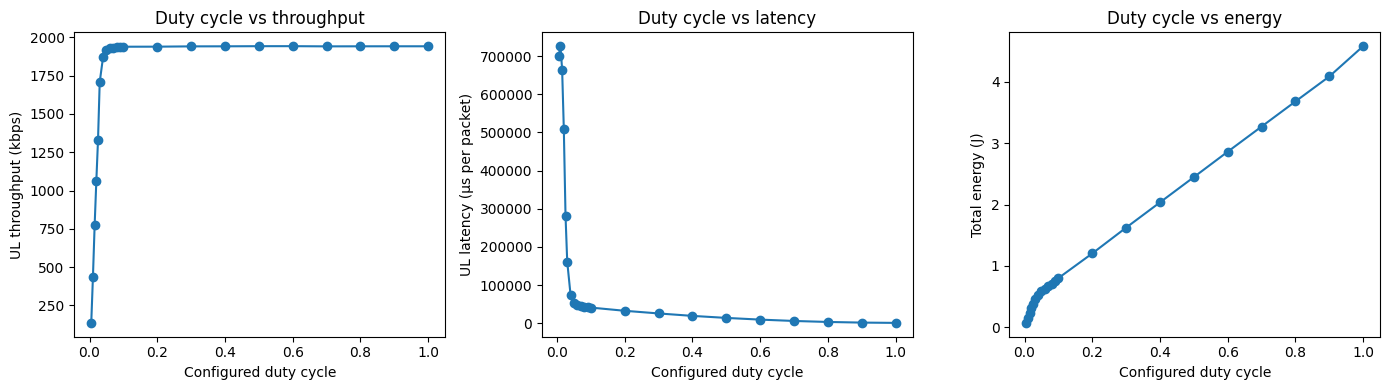

State dimension: (4,)
Number of actions: 22
Duty cycle actions: [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

Training DQN...
Episode 20/500  Reward=-0.652  AvgEnergy_J=1.92eps=0.928
Episode 40/500  Reward=-1.010  AvgEnergy_J=1.45eps=0.852
Episode 60/500  Reward=0.151  AvgEnergy_J=0.97eps=0.776
Episode 80/500  Reward=0.319  AvgEnergy_J=1.05eps=0.700
Episode 100/500  Reward=-0.613  AvgEnergy_J=1.75eps=0.624
Episode 120/500  Reward=2.051  AvgEnergy_J=0.72eps=0.548
Episode 140/500  Reward=1.058  AvgEnergy_J=1.20eps=0.472
Episode 160/500  Reward=1.328  AvgEnergy_J=1.19eps=0.396
Episode 180/500  Reward=1.831  AvgEnergy_J=0.88eps=0.320
Episode 200/500  Reward=1.422  AvgEnergy_J=1.04eps=0.244
Episode 220/500  Reward=2.235  AvgEnergy_J=0.52eps=0.168
Episode 240/500  Reward=1.733  AvgEnergy_J=0.88eps=0.092
Episode 260/500  Reward=2.458  AvgEnergy_J=0.62eps=0.050
Episode 280/500  Reward=0.406  AvgEnergy_J=1.42eps=0.

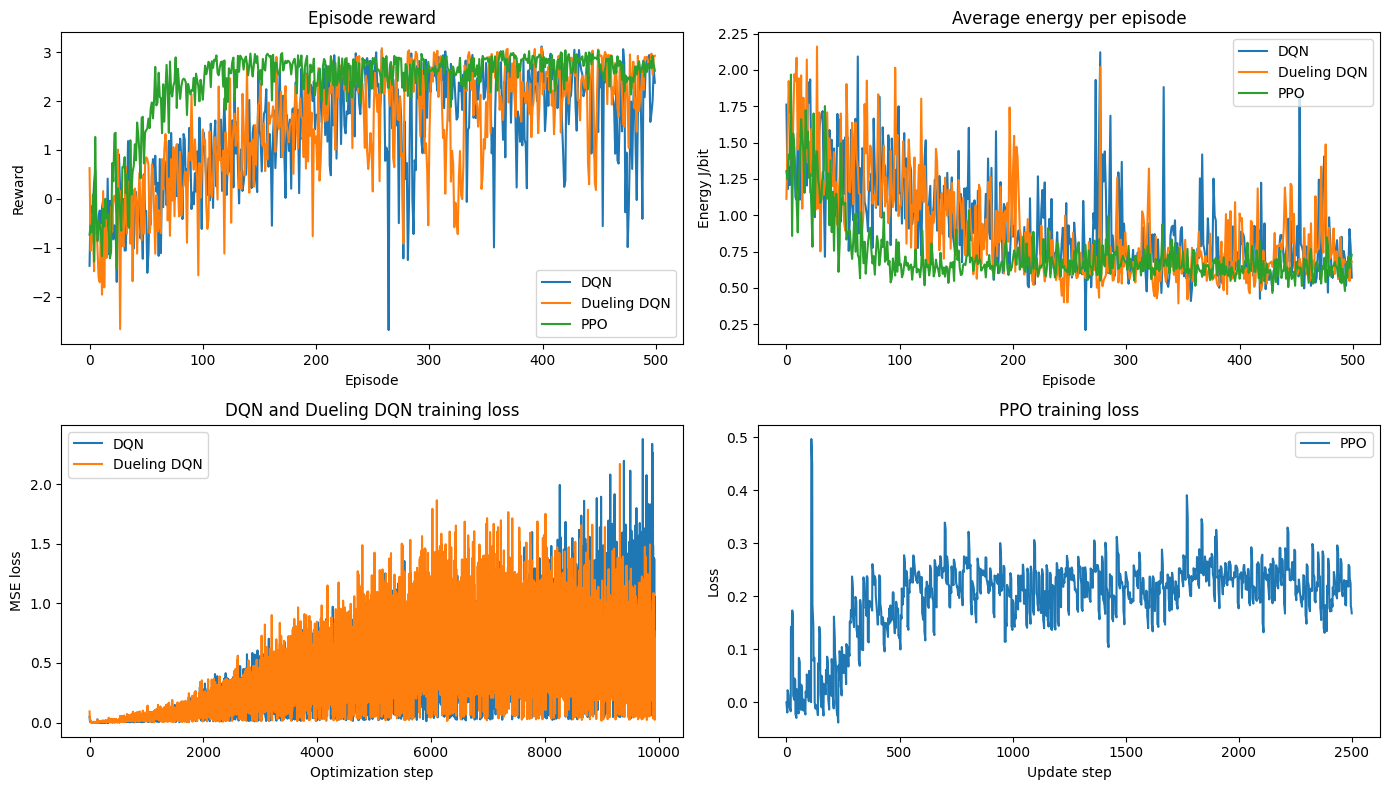

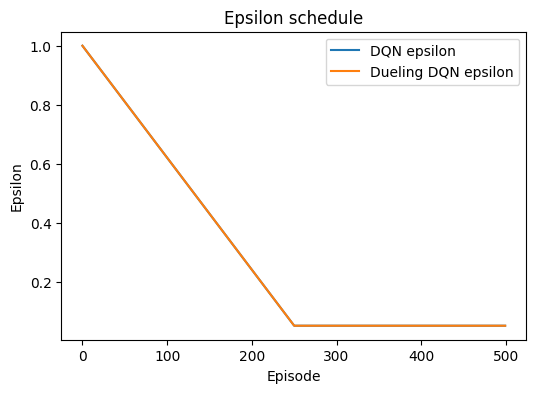


Policy evaluation (energy J/bit, latency us):
Random   : 1.44940322595 162382.7719
Fixed 0.1: 0.8003853017 41189.658
DQN      : 0.54786682122 123116.0468
Dueling  : 0.5889226235 54588.7484
PPO      : 0.5366043735999999 73091.97369999999


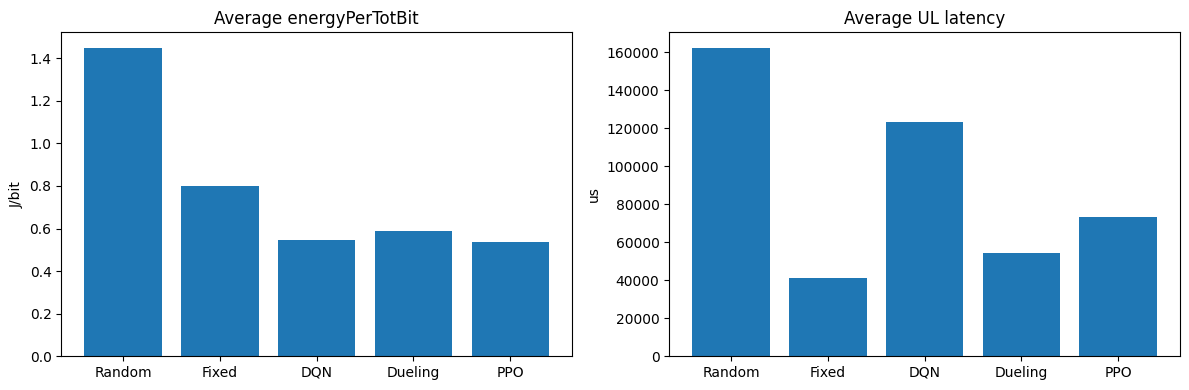

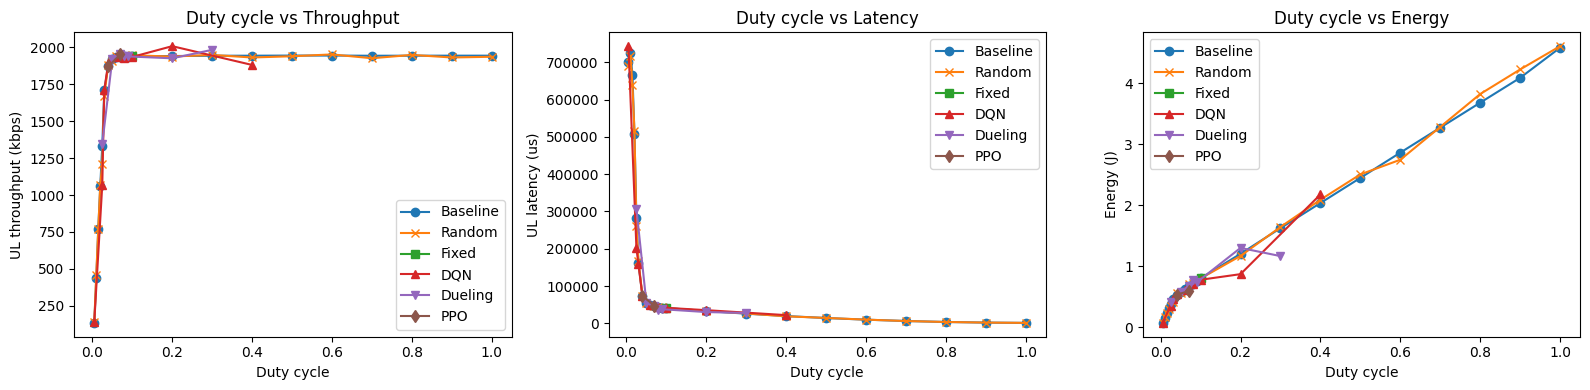


DQN Summary and Plot


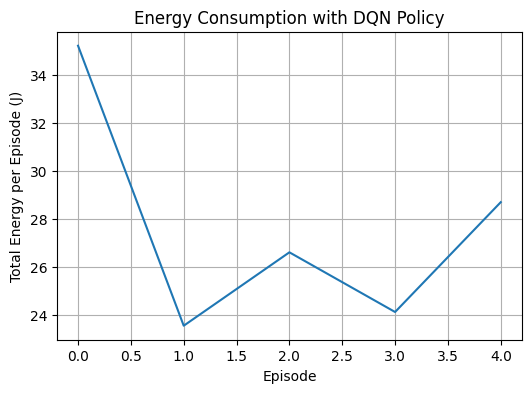

Baseline Energy Consumption (before training): 1.449403
DQN Energy Consumption (after training): 0.547867
DQN achieved lower energy consumption after training!
Dueling DQN Summary and Plot


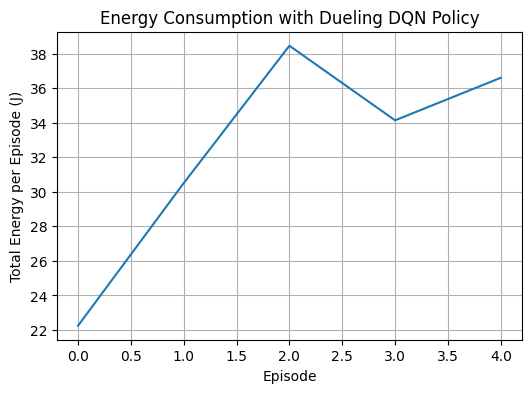

Baseline Energy Consumption (before training): 1.449403
Dueling DQN Energy Consumption (after training): 0.588923
Dueling DQN achieved lower energy consumption after training!

PPO Summary and Plot


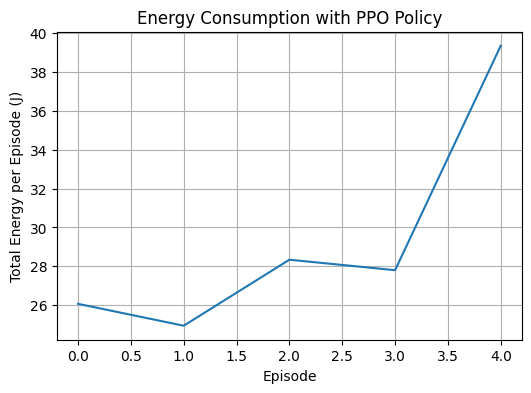

Baseline Energy Consumption (before training): 1.449403
PPO Energy Consumption (after training): 0.536604
PPO achieved lower energy consumption after training!


In [7]:
# ================================================================
# Offline RL for TWT Duty-Cycle Optimization (DQN, Dueling DQN, PPO)
# ================================================================

import re
import random
from collections import deque
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

LOG_PATH = "wns3DutyCycleResults.log"  # ns-3 log file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ================================================================
# 1. Load and inspect the ns-3 duty cycle log
# ================================================================

def load_duty_cycle_log(path: str) -> pd.DataFrame:
    """Parse ns-3 key=value style log into a DataFrame."""
    rows = []
    with open(path) as f:
        for line in f:
            pairs = re.findall(r"(\w+)=([-0-9\.eE\+]+)", line)
            if not pairs:
                continue
            d = {}
            for k, v in pairs:
                try:
                    d[k] = float(v)
                except ValueError:
                    d[k] = v
            rows.append(d)
    df = pd.DataFrame(rows)
    df = df.dropna(
        subset=[
            "ConfiguredDutyCycle",
            "UL_throughput_kbps",
            "UL_latency_usPerPkt",
            "energyPerTotBit_JPerBit",
        ]
    )
    df = df.sort_values("ConfiguredDutyCycle").reset_index(drop=True)
    return df

df = load_duty_cycle_log(LOG_PATH)
print(df.head())
print("\nUnique duty cycles:", sorted(df["ConfiguredDutyCycle"].unique()))

# ================================================================
# Baseline plots: duty cycle vs throughput, latency, energy
# ================================================================
grouped = df.groupby("ConfiguredDutyCycle").mean(numeric_only=True)

duty = grouped.index.values
throughput = grouped["UL_throughput_kbps"].values
latency = grouped["UL_latency_usPerPkt"].values
energy_J = grouped["energy_J"].values if "energy_J" in grouped.columns else None
energy_per_bit = grouped["energyPerTotBit_JPerBit"].values

plt.figure(figsize=(14, 4))

# Duty cycle vs throughput
plt.subplot(1, 3, 1)
plt.plot(duty, throughput, marker="o")
plt.xlabel("Configured duty cycle")
plt.ylabel("UL throughput (kbps)")
plt.title("Duty cycle vs throughput")

# Duty cycle vs latency
plt.subplot(1, 3, 2)
plt.plot(duty, latency, marker="o")
plt.xlabel("Configured duty cycle")
plt.ylabel("UL latency (µs per packet)")
plt.title("Duty cycle vs latency")

# Duty cycle vs energy (choose one metric)
plt.subplot(1, 3, 3)
if energy_J is not None:
    plt.plot(duty, energy_J, marker="o")
    plt.ylabel("Total energy (J)")
else:
    plt.plot(duty, energy_per_bit, marker="o")
    plt.ylabel("Energy per bit (J/bit)")
plt.xlabel("Configured duty cycle")
plt.title("Duty cycle vs energy")

plt.tight_layout()
plt.show()


# ================================================================
# 2. Offline environment: TwtEnv
# ================================================================

class TwtEnv:
    """
    Offline, gym-like environment backed by ns-3 log data.
    State: normalized [throughput, latency, energyPerBit, effectiveDutyCycle]
    Action: index into set of unique duty cycles
    Reward: -alpha * energy - beta * latency + gamma * throughput
    """

    def __init__(
        self,
        df: pd.DataFrame,
        alpha: float = 0.6,
        beta: float = 0.2,
        gamma: float = 0.2,
        max_steps_per_episode: int = 20,
        seed: int = 0,
    ):
        self.df = df.copy().reset_index(drop=True)
        self.rng = np.random.default_rng(seed)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.max_steps = max_steps_per_episode

        # actions are unique configured duty cycles
        self.actions = sorted(self.df["ConfiguredDutyCycle"].unique().tolist())
        self.action_dim = len(self.actions)

        self._prep_features()
        self.current_row_idx = None
        self.step_count = 0

    def _prep_features(self):
        cols = [
            "UL_throughput_kbps",
            "UL_latency_usPerPkt",
            "energyPerTotBit_JPerBit",
            "EffectiveDutyCycle",
        ]
        self.feature_cols = cols
        self.df = self.df.dropna(subset=cols)

        self.norm_stats = {}
        for c in cols:
            v = self.df[c].values
            vmin, vmax = v.min(), v.max()
            if vmax - vmin < 1e-9:
                self.df[c + "_norm"] = 0.0
                self.norm_stats[c] = (vmin, vmax)
            else:
                self.df[c + "_norm"] = (v - vmin) / (vmax - vmin)
                self.norm_stats[c] = (vmin, vmax)

    def _row_to_state(self, row: pd.Series) -> np.ndarray:
        return row[[c + "_norm" for c in self.feature_cols]].to_numpy(
            dtype=np.float32
        )

    def _compute_reward(self, row: pd.Series) -> float:
        t = row["UL_throughput_kbps_norm"]
        l = row["UL_latency_usPerPkt_norm"]
        e = row["energyPerTotBit_JPerBit_norm"]
        r = -self.alpha * e - self.beta * l + self.gamma * t
        return float(r)

    def reset(self):
        self.step_count = 0
        self.current_row_idx = self.rng.integers(0, len(self.df))
        row = self.df.iloc[self.current_row_idx]
        state = self._row_to_state(row)
        return state

    def step(self, action_idx: int):
        self.step_count += 1
        duty = self.actions[action_idx]
        subset = self.df[self.df["ConfiguredDutyCycle"] == duty]
        if subset.empty:
            subset = self.df

        row = subset.sample(
            n=1, random_state=self.rng.integers(1_000_000_000)
        ).iloc[0]
        self.current_row_idx = row.name

        next_state = self._row_to_state(row)
        reward = self._compute_reward(row)
        done = self.step_count >= self.max_steps
        info = {
          "ConfiguredDutyCycle": row["ConfiguredDutyCycle"],
          "energyPerTotBit_JPerBit": row["energyPerTotBit_JPerBit"],
          "energy_J": row.get("energy_J", 0.0),   # <-- ADD THIS
          "UL_latency_usPerPkt": row["UL_latency_usPerPkt"],
          "UL_throughput_kbps": row["UL_throughput_kbps"],
        }
        return next_state, reward, done, info


env = TwtEnv(df, max_steps_per_episode=20)
s0 = env.reset()
print("State dimension:", s0.shape)
print("Number of actions:", env.action_dim)
print("Duty cycle actions:", env.actions)

# ================================================================
# 3. Shared components: Q networks, replay buffer
# ================================================================

class QNetwork(nn.Module):
    """Standard DQN network."""
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes=(128, 64)):
        super().__init__()
        layers = []
        last_dim = state_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last_dim, h))
            layers.append(nn.ReLU())
            last_dim = h
        layers.append(nn.Linear(last_dim, action_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class DuelingQNetwork(nn.Module):
    """Dueling DQN network with separate value and advantage streams."""
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes=(128, 64)):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
        )
        self.value = nn.Linear(hidden_sizes[1], 1)
        self.advantage = nn.Linear(hidden_sizes[1], action_dim)

    def forward(self, x):
        f = self.feature(x)
        value = self.value(f)              # shape [B, 1]
        advantage = self.advantage(f)      # shape [B, A]
        # centralize advantage
        advantage = advantage - advantage.mean(dim=1, keepdim=True)
        q = value + advantage
        return q


class ReplayBuffer:
    def __init__(self, capacity: int = 50_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# ================================================================
# 4. Training function for DQN and Dueling DQN
# ================================================================

def train_qlearning(
    env: TwtEnv,
    net_cls,
    num_episodes: int = 500,
    batch_size: int = 64,
    gamma: float = 0.99,
    lr: float = 1e-3,
    epsilon_start: float = 1.0,
    epsilon_end: float = 0.05,
    epsilon_decay_episodes: int = 250,
    target_update_freq: int = 200,
):
    state_dim = len(env.feature_cols)
    action_dim = env.action_dim

    policy_net = net_cls(state_dim, action_dim).to(device)
    target_net = net_cls(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    buffer = ReplayBuffer(capacity=50_000)

    episode_rewards = []
    episode_energies = []
    losses = []
    epsilons = []

    global_step = 0

    def epsilon_by_episode(ep):
        frac = min(1.0, ep / float(epsilon_decay_episodes))
        return epsilon_start + frac * (epsilon_end - epsilon_start)

    for ep in range(num_episodes):
        state = env.reset()
        ep_reward = 0.0
        ep_energy = 0.0

        epsilon = epsilon_by_episode(ep)
        epsilons.append(epsilon)

        done = False
        while not done:
            global_step += 1

            if random.random() < epsilon:
                action = random.randrange(action_dim)
            else:
                with torch.no_grad():
                    s_t = torch.tensor(
                        state, dtype=torch.float32, device=device
                    ).unsqueeze(0)
                    q_vals = policy_net(s_t)
                    action = int(torch.argmax(q_vals, dim=1).item())

            next_state, reward, done, info = env.step(action)
            ep_reward += reward
            ep_energy += info["energy_J"]

            buffer.push(state, action, reward, next_state, done)
            state = next_state

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(
                    batch_size
                )

                states_t = torch.tensor(
                    states, dtype=torch.float32, device=device
                )
                actions_t = torch.tensor(
                    actions, dtype=torch.int64, device=device
                ).unsqueeze(1)
                rewards_t = torch.tensor(
                    rewards, dtype=torch.float32, device=device
                ).unsqueeze(1)
                next_states_t = torch.tensor(
                    next_states, dtype=torch.float32, device=device
                )
                dones_t = torch.tensor(
                    dones, dtype=torch.float32, device=device
                ).unsqueeze(1)

                q_values = policy_net(states_t).gather(1, actions_t)
                with torch.no_grad():
                    next_q_values = target_net(next_states_t).max(
                        1, keepdim=True
                    )[0]
                    target = rewards_t + gamma * (1.0 - dones_t) * next_q_values

                loss = nn.MSELoss()(q_values, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(ep_reward)
        episode_energies.append(ep_energy / env.max_steps)

        if (ep + 1) % 20 == 0:
            print(
                f"Episode {ep+1}/{num_episodes}  "
                f"Reward={ep_reward:.3f}  "
                f"AvgEnergy_J={ep_energy/env.max_steps:.2f}"
                f"eps={epsilon:.3f}"
            )

    results = {
        "policy_net": policy_net,
        "target_net": target_net,
        "episode_rewards": episode_rewards,
        "episode_energies": episode_energies,
        "losses": losses,
        "epsilons": epsilons,
    }
    return results

print("\nTraining DQN...")
dqn_results = train_qlearning(env, QNetwork)

print("\nTraining Dueling DQN...")
dueling_results = train_qlearning(env, DuelingQNetwork)

# ================================================================
# 5. PPO implementation
# ================================================================

class ActorCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_sizes=(128, 64)):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(hidden_sizes[1], action_dim)
        self.value_head = nn.Linear(hidden_sizes[1], 1)

    def forward(self, x):
        f = self.shared(x)
        logits = self.policy_head(f)
        value = self.value_head(f)
        return logits, value


def train_ppo(
    env: TwtEnv,
    num_episodes: int = 500,
    gamma: float = 0.99,
    lam: float = 0.95,
    clip_eps: float = 0.2,
    lr: float = 3e-4,
    update_epochs: int = 5,
    batch_size: int = 64,
):
    state_dim = len(env.feature_cols)
    action_dim = env.action_dim

    ac = ActorCritic(state_dim, action_dim).to(device)
    optimizer = optim.Adam(ac.parameters(), lr=lr)

    episode_rewards = []
    episode_energies = []
    losses = []

    for ep in range(num_episodes):
        states = []
        actions = []
        log_probs = []
        rewards = []
        dones = []
        values = []
        info_energy = 0.0

        state = env.reset()
        done = False
        while not done:
            s_t = torch.tensor(
                state, dtype=torch.float32, device=device
            ).unsqueeze(0)
            logits, value = ac(s_t)
            dist = torch.distributions.Categorical(logits=logits)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            next_state, reward, done, info = env.step(int(action.item()))
            info_energy += info["energy_J"]

            states.append(state)
            actions.append(action.item())
            log_probs.append(log_prob.item())
            rewards.append(reward)
            dones.append(float(done))
            values.append(value.item())

            state = next_state

        episode_rewards.append(sum(rewards))
        episode_energies.append(info_energy / env.max_steps)

        # convert to tensors
        states_t = torch.tensor(states, dtype=torch.float32, device=device)
        actions_t = torch.tensor(actions, dtype=torch.int64, device=device)
        old_log_probs_t = torch.tensor(
            log_probs, dtype=torch.float32, device=device
        )
        rewards_t = torch.tensor(rewards, dtype=torch.float32, device=device)
        dones_t = torch.tensor(dones, dtype=torch.float32, device=device)
        values_t = torch.tensor(values, dtype=torch.float32, device=device)

        # compute advantages using GAE
        advantages = []
        gae = 0.0
        with torch.no_grad():
            _, last_value = ac(
                torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            )
            last_value = last_value.item()
        for t in reversed(range(len(rewards))):
            if t == len(rewards) - 1:
                next_value = last_value
            else:
                next_value = values[t + 1]
            delta = rewards[t] + gamma * next_value * (1.0 - dones[t]) - values[t]
            gae = delta + gamma * lam * (1.0 - dones[t]) * gae
            advantages.insert(0, gae)
        advantages_t = torch.tensor(advantages, dtype=torch.float32, device=device)
        returns_t = advantages_t + values_t

        # normalize advantages
        advantages_t = (advantages_t - advantages_t.mean()) / (
            advantages_t.std() + 1e-8
        )

        # PPO update
        for _ in range(update_epochs):
            idx = np.arange(len(states))
            np.random.shuffle(idx)
            for start in range(0, len(idx), batch_size):
                end = start + batch_size
                batch_idx = idx[start:end]

                batch_states = states_t[batch_idx]
                batch_actions = actions_t[batch_idx]
                batch_old_log_probs = old_log_probs_t[batch_idx]
                batch_advantages = advantages_t[batch_idx]
                batch_returns = returns_t[batch_idx]

                logits, values_pred = ac(batch_states)
                dist = torch.distributions.Categorical(logits=logits)
                new_log_probs = dist.log_prob(batch_actions)
                ratio = torch.exp(new_log_probs - batch_old_log_probs)

                # clipped surrogate objective
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(
                    ratio, 1.0 - clip_eps, 1.0 + clip_eps
                ) * batch_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = nn.MSELoss()(values_pred.squeeze(-1), batch_returns)
                entropy_loss = dist.entropy().mean()

                loss = policy_loss + 0.5 * value_loss - 0.01 * entropy_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                losses.append(loss.item())

        if (ep + 1) % 20 == 0:
            print(
                f"PPO Episode {ep+1}/{num_episodes}  "
                f"Reward={episode_rewards[-1]:.3f}  "
                f"AvgEnergy_J={episode_energies[-1]:.2f}"
            )

    results = {
        "ac": ac,
        "episode_rewards": episode_rewards,
        "episode_energies": episode_energies,
        "losses": losses,
    }
    return results

print("\nTraining PPO...")
ppo_results = train_ppo(env)

# ================================================================
# 6. Training curves comparison
# ================================================================

def plot_training_curves():
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))

    axs[0, 0].plot(dqn_results["episode_rewards"], label="DQN")
    axs[0, 0].plot(dueling_results["episode_rewards"], label="Dueling DQN")
    axs[0, 0].plot(ppo_results["episode_rewards"], label="PPO")
    axs[0, 0].set_title("Episode reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Reward")
    axs[0, 0].legend()

    axs[0, 1].plot(dqn_results["episode_energies"], label="DQN")
    axs[0, 1].plot(dueling_results["episode_energies"], label="Dueling DQN")
    axs[0, 1].plot(ppo_results["episode_energies"], label="PPO")
    axs[0, 1].set_title("Average energy per episode")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Energy J/bit")
    axs[0, 1].legend()

    axs[1, 0].plot(dqn_results["losses"], label="DQN")
    axs[1, 0].plot(dueling_results["losses"], label="Dueling DQN")
    axs[1, 0].set_title("DQN and Dueling DQN training loss")
    axs[1, 0].set_xlabel("Optimization step")
    axs[1, 0].set_ylabel("MSE loss")
    axs[1, 0].legend()

    axs[1, 1].plot(ppo_results["losses"], label="PPO")
    axs[1, 1].set_title("PPO training loss")
    axs[1, 1].set_xlabel("Update step")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

    # epsilon schedule for DQN and Dueling
    plt.figure(figsize=(6, 4))
    plt.plot(dqn_results["epsilons"], label="DQN epsilon")
    plt.plot(dueling_results["epsilons"], label="Dueling DQN epsilon")
    plt.title("Epsilon schedule")
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.legend()
    plt.show()

plot_training_curves()

# ================================================================
# 7. Evaluate learned policies vs baselines
# ================================================================

def run_policy(env: TwtEnv, policy_fn, num_episodes: int = 500):
    avg_energy = []
    avg_latency = []
    for _ in range(num_episodes):
        state = env.reset()
        ep_energy = 0.0
        ep_latency = 0.0
        done = False
        while not done:
            action = policy_fn(state)
            next_state, reward, done, info = env.step(action)
            ep_energy += info["energy_J"]
            ep_latency += info["UL_latency_usPerPkt"]
            state = next_state
        avg_energy.append(ep_energy / env.max_steps)
        avg_latency.append(ep_latency / env.max_steps)
    return np.mean(avg_energy), np.mean(avg_latency)

# random policy
def random_policy(state):
    return random.randrange(env.action_dim)

# fixed policy at duty cycle approx 0.1
fixed_target = 0.1
fixed_action = int(np.argmin(np.abs(np.array(env.actions) - fixed_target)))

def fixed_policy(state):
    return fixed_action

# greedy DQN policies
dqn_policy_net = dqn_results["policy_net"]
dueling_policy_net = dueling_results["policy_net"]
ppo_ac = ppo_results["ac"]

def dqn_policy(state):
    with torch.no_grad():
        s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_vals = dqn_policy_net(s_t)
        return int(torch.argmax(q_vals, dim=1).item())

def dueling_policy(state):
    with torch.no_grad():
        s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q_vals = dueling_policy_net(s_t)
        return int(torch.argmax(q_vals, dim=1).item())

def ppo_policy(state):
    with torch.no_grad():
        s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        logits, _ = ppo_ac(s_t)
        dist = torch.distributions.Categorical(logits=logits)
        action = torch.argmax(dist.probs, dim=1)
        return int(action.item())

rand_energy, rand_lat = run_policy(env, random_policy)
fixed_energy, fixed_lat = run_policy(env, fixed_policy)
dqn_energy, dqn_lat = run_policy(env, dqn_policy)
duel_energy, duel_lat = run_policy(env, dueling_policy)
ppo_energy, ppo_lat = run_policy(env, ppo_policy)

print("\nPolicy evaluation (energy J/bit, latency us):")
print("Random   :", rand_energy, rand_lat)
print("Fixed 0.1:", fixed_energy, fixed_lat)
print("DQN      :", dqn_energy, dqn_lat)
print("Dueling  :", duel_energy, duel_lat)
print("PPO      :", ppo_energy, ppo_lat)

labels = ["Random", "Fixed", "DQN", "Dueling", "PPO"]
energies = [rand_energy, fixed_energy, dqn_energy, duel_energy, ppo_energy]
latencies = [rand_lat, fixed_lat, dqn_lat, duel_lat, ppo_lat]

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(labels, energies)
axs[0].set_title("Average energyPerTotBit")
axs[0].set_ylabel("J/bit")

axs[1].bar(labels, latencies)
axs[1].set_title("Average UL latency")
axs[1].set_ylabel("us")

plt.tight_layout()
plt.show()

# ================================================================
# 8. Collect detailed duty-cycle behavior from trained policies
# ================================================================

def collect_policy_samples(env: TwtEnv, policy_fn, num_episodes: int = 50):
    """
    Roll out a policy in the offline env and record step-by-step metrics.
    Returns a DataFrame with one row per step.
    """
    records = []
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action = policy_fn(state)
            next_state, reward, done, info = env.step(action)

            records.append({
                "ConfiguredDutyCycle": info["ConfiguredDutyCycle"],
                "UL_throughput_kbps": info["UL_throughput_kbps"],
                "UL_latency_usPerPkt": info["UL_latency_usPerPkt"],
                "energy_J": info["energy_J"],
                "energyPerTotBit_JPerBit": info["energyPerTotBit_JPerBit"],
            })

            state = next_state

    return pd.DataFrame(records)

    # Collect samples from each policy
df_random = collect_policy_samples(env, random_policy)
df_fixed  = collect_policy_samples(env, fixed_policy)
df_dqn    = collect_policy_samples(env, dqn_policy)
df_duel   = collect_policy_samples(env, dueling_policy)
df_ppo    = collect_policy_samples(env, ppo_policy)

# Baseline ns-3 behavior directly from raw log
baseline_group = df.groupby("ConfiguredDutyCycle").mean(numeric_only=True)



# ================================================================
# 9. Plot duty cycle vs throughput, latency, energy for all models
# ================================================================

def plot_dutycycle_metric_comparison():
    def group(df_pol):
        return df_pol.groupby("ConfiguredDutyCycle").mean(numeric_only=True)

    g_base = baseline_group
    g_rand = group(df_random)
    g_fix  = group(df_fixed)
    g_dqn  = group(df_dqn)
    g_duel = group(df_duel)
    g_ppo  = group(df_ppo)

    plt.figure(figsize=(16,4))

    # Throughput
    plt.subplot(1,3,1)
    plt.plot(g_base.index, g_base["UL_throughput_kbps"], marker="o", label="Baseline")
    plt.plot(g_rand.index, g_rand["UL_throughput_kbps"], marker="x", label="Random")
    plt.plot(g_fix.index,  g_fix["UL_throughput_kbps"],  marker="s", label="Fixed")
    plt.plot(g_dqn.index,  g_dqn["UL_throughput_kbps"],  marker="^", label="DQN")
    plt.plot(g_duel.index, g_duel["UL_throughput_kbps"], marker="v", label="Dueling")
    plt.plot(g_ppo.index,  g_ppo["UL_throughput_kbps"],  marker="d", label="PPO")
    plt.title("Duty cycle vs Throughput")
    plt.xlabel("Duty cycle")
    plt.ylabel("UL throughput (kbps)")
    plt.legend()

    # Latency
    plt.subplot(1,3,2)
    plt.plot(g_base.index, g_base["UL_latency_usPerPkt"], marker="o", label="Baseline")
    plt.plot(g_rand.index, g_rand["UL_latency_usPerPkt"], marker="x", label="Random")
    plt.plot(g_fix.index,  g_fix["UL_latency_usPerPkt"],  marker="s", label="Fixed")
    plt.plot(g_dqn.index,  g_dqn["UL_latency_usPerPkt"],  marker="^", label="DQN")
    plt.plot(g_duel.index, g_duel["UL_latency_usPerPkt"], marker="v", label="Dueling")
    plt.plot(g_ppo.index,  g_ppo["UL_latency_usPerPkt"],  marker="d", label="PPO")
    plt.title("Duty cycle vs Latency")
    plt.xlabel("Duty cycle")
    plt.ylabel("UL latency (us)")
    plt.legend()

    # Energy
    plt.subplot(1,3,3)
    plt.plot(g_base.index, g_base["energy_J"], marker="o", label="Baseline")
    plt.plot(g_rand.index, g_rand["energy_J"], marker="x", label="Random")
    plt.plot(g_fix.index,  g_fix["energy_J"],  marker="s", label="Fixed")
    plt.plot(g_dqn.index,  g_dqn["energy_J"],  marker="^", label="DQN")
    plt.plot(g_duel.index, g_duel["energy_J"], marker="v", label="Dueling")
    plt.plot(g_ppo.index,  g_ppo["energy_J"],  marker="d", label="PPO")
    plt.title("Duty cycle vs Energy")
    plt.xlabel("Duty cycle")
    plt.ylabel("Energy (J)")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plot
plot_dutycycle_metric_comparison()


# ================================================================
# 10. Episode-wise energy plot and textual summary (DQN example)
# ================================================================

def plot_energy_curve(agent_name, episode_energies):
    total_energy = np.array(episode_energies) * env.max_steps
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(total_energy)), total_energy)
    plt.title(f"Energy Consumption with {agent_name} Policy")
    plt.xlabel("Episode")
    plt.ylabel("Total Energy per Episode (J)")
    plt.grid(True)
    plt.show()

print("\n========================")
print("DQN Summary and Plot")
print("========================")
plot_energy_curve("DQN", dqn_results["episode_energies"][:5])

baseline_energy = rand_energy          # baseline = random policy
dqn_final_energy = dqn_energy          # learned policy

print(f"Baseline Energy Consumption (before training): {baseline_energy:.6f}")
print(f"DQN Energy Consumption (after training): {dqn_final_energy:.6f}")

if dqn_final_energy < baseline_energy:
    print("DQN achieved lower energy consumption after training!")
else:
    print("DQN did not yet improve — try more episodes or tuning.")


    print("\n========================")
print("Dueling DQN Summary and Plot")
print("========================")
plot_energy_curve("Dueling DQN", dueling_results["episode_energies"][:5])

print(f"Baseline Energy Consumption (before training): {baseline_energy:.6f}")
print(f"Dueling DQN Energy Consumption (after training): {duel_energy:.6f}")

if duel_energy < baseline_energy:
    print("Dueling DQN achieved lower energy consumption after training!")
else:
    print("Dueling DQN did not yet improve.")


print("\n========================")
print("PPO Summary and Plot")
print("========================")
plot_energy_curve("PPO", ppo_results["episode_energies"][:5])

print(f"Baseline Energy Consumption (before training): {baseline_energy:.6f}")
print(f"PPO Energy Consumption (after training): {ppo_energy:.6f}")

if ppo_energy < baseline_energy:
    print("PPO achieved lower energy consumption after training!")
else:
    print("PPO did not yet improve.")





